In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Autoformer/

/content/drive/MyDrive/Autoformer


In [3]:
!pip install reformer-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for axial-positional-embedding: filename=axial_positional_embedding-0.2.1-py3-none-any.whl size=2882 sha256=f9440115af166fc41af457bdca3e2446d8c7f2b86404c192493f6e7b0ef06c27
  Stored in directory: /root/.cache/pip/wheels/b1/cb/39/7ce7ff2d2fd37cfe1fe7b3a3c43cf410632b2ad3b3f3986d73
Successfully built axial-positional-embedding


# I. Khai bao mo hinh

In [4]:
import argparse
import os
import torch
from exp.exp_main import Exp_Main # exp stands for experiments
import random
import numpy as np
from utils.tools import dotdict
import pandas as pd

In [5]:
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

parser = argparse.ArgumentParser(description='Autoformer & Transformer family for Time Series Forecasting')

# basic config
parser.add_argument('--is_training', type=int, required=True, default=1, help='status')
parser.add_argument('--model_id', type=str, required=True, default='test', help='model id')
parser.add_argument('--model', type=str, required=True, default='Autoformer',
                    help='model name, options: [Autoformer, Informer, Transformer]')

# data loader
parser.add_argument('--data', type=str, required=True, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')#预测类别
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=24, help='prediction sequence length')

# model define
parser.add_argument('--bucket_size', type=int, default=4, help='for Reformer')
parser.add_argument('--n_hashes', type=int, default=4, help='for Reformer')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')#encoder input size
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')#decoder input size
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')#dimension of model
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')#num of heads
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')#num of encoder layers
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')#num of decoder layers
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')#dimension of fcn
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.05, help='dropout')#dropout
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')#time features encoding
parser.add_argument('--activation', type=str, default='gelu', help='activation')#default=gelu
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in encoder')#encoderoutput_attention
parser.add_argument('--do_predict', action='store_true', help='whether to predict unseen future data')
parser.add_argument('--pretrained', type=str, default='', help='pretrained weight path')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')# num_workers
parser.add_argument('--itr', type=int, default=2, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')#bathsize
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')#lr
parser.add_argument('--des', type=str, default='test', help='exp description')#test
parser.add_argument('--loss', type=str, default='mse', help='loss function')#loss is mse
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')#adjust learning-rate
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# args = parser.parse_args()
args = dotdict()
########################## Main args #########################
# args.root_path = '/content/drive/MyDrive/Forecasting/FEDformer/dataset/B/'
# args.data_path = 'data_011019-080122.csv'
# args.target = 'close'

args.root_path = '/content/drive/MyDrive/Forecasting/'
args.data_path = 'dataset_19772020_daily(RF-WL).csv'
args.target = 'RF_DongTam'
args.batch_size = 256
args.data = 'custom'
args.features = 'S'
##############################################################
args.learning_rate = 0.0001
args.train_epochs = 20
args.checkpoints = './checkpoints/'
args.model_id='B_96_24'
args.model = 'Autoformer'
args.seq_len = 96
args.label_len = 48
args.pred_len = 24
args.itr = 5
args.factor = 3
# args.enc_in = 5
# args.dec_in = 5
# args.c_out = 5

args.enc_in = 1
args.dec_in = 1
args.c_out = 1
#args.pretrained = ''
##############################################################

args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = False
args.use_multi_gpu = False
# if args.use_gpu and args.use_multi_gpu: 
#     args.dvices = args.devices.replace(' ', '')
#     device_ids = args.devices.split(',')
#     args.device_ids = [int(id_) for id_ in device_ids]
#     args.gpu = args.device_ids[0]
# args.freq = 'h'
args.freq = "d"
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.e_layers = 2
args.d_layers = 1
args.n_heads = 8
args.d_model = 512
args.des = 'Exp'
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = True
args.output_attention = False
args.patience= 3
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
print('Args in experiment:')
print(args)

Exp = Exp_Main

Args in experiment:
{'root_path': '/content/drive/MyDrive/Forecasting/', 'data_path': 'dataset_19772020_daily(RF-WL).csv', 'target': 'RF_DongTam', 'batch_size': 256, 'data': 'custom', 'features': 'S', 'learning_rate': 0.0001, 'train_epochs': 20, 'checkpoints': './checkpoints/', 'model_id': 'B_96_24', 'model': 'Autoformer', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'itr': 5, 'factor': 1, 'enc_in': 1, 'dec_in': 1, 'c_out': 1, 'des': 'Exp', 'dropout': 0.05, 'num_workers': 10, 'gpu': 0, 'lradj': 'type1', 'devices': '0', 'use_gpu': False, 'use_multi_gpu': False, 'freq': 'd', 'bucket_size': 4, 'n_hashes': 4, 'is_trainging': True, 'e_layers': 2, 'd_layers': 1, 'n_heads': 8, 'd_model': 512, 'd_ff': 2048, 'moving_avg': 25, 'distil': True, 'output_attention': False, 'patience': 3, 'embed': 'timeF', 'activation': 'gelu', 'use_amp': False, 'loss': 'mse'}


# II. Training and Testing

## 0. XQHh_Nhatle data processing

In [ ]:
import pandas as pd
df = pd.read_excel("/content/drive/MyDrive/Forecasting/datasets/XQHh_Nhatle_2020.xlsx", sheet_name='QHh_2020')

## LT_2021_test

In [ ]:
args.root_path = '/content/drive/MyDrive/DATA/'
args.data_path = 'LT_2021_Copy.csv'
args.target = 'LT_H'
args.batch_size = 256
args.data = 'custom'
args.features = 'MS'
args.seq_len = 4
args.label_len = 4
args.pred_len = 1
args.freq = "h"
# args.use_gpu = True
args.use_gpu = False
args.model_id="LT_2021_Test"
args.patience=10
args.train_epochs = 100
args.itr = 5

In [ ]:
### scale = False, seq_len = 8, patience=10
args.enc_in = 1
args.dec_in = 1

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):#itr epoch，parser.add_argument('--itr', type=int, default=2, help='experiments times')
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args) # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting) # setting
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)

print("end========>>>>>>>>>>")


Use CPU
1
>>>>>>>start training : LT_2021_Test_Autoformer_custom_ftMS_sl4_ll4_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
                 date   LT_H
6271   9/18/2021 8:00  1.047
6272   9/18/2021 9:00  1.033
6273  9/18/2021 10:00  1.020
6274  9/18/2021 11:00  1.007
6275  9/18/2021 12:00  0.993
...               ...    ...
7898  11/25/2021 3:00  0.510
7899  11/25/2021 4:00  0.515
7900  11/25/2021 5:00  0.520
7901  11/25/2021 6:00  0.525
7902  11/25/2021 7:00  0.530

[1632 rows x 2 columns]
Mean values of features: [-0.11064805]
Std values of features: [0.13839084]
train 5528
                 date   LT_H
6271   9/18/2021 8:00  1.047
6272   9/18/2021 9:00  1.033
6273  9/18/2021 10:00  1.020
6274  9/18/2021 11:00  1.007
6275  9/18/2021 12:00  0.993
...               ...    ...
7898  11/25/2021 3:00  0.510
7899  11/25/2021 4:00  0.515
7900  11/25/2021 5:00  0.520
7901  11/25/2021 6:00  0.525
7902  11/25/2021 7:00  0.530

[1632 rows x 2 columns]
Mean valu

## LT_2022


In [ ]:
args.root_path = '/content/drive/MyDrive/DATA/'
args.data_path = 'LT_2022.csv'
args.target = 'LT_H'
args.batch_size = 256
args.data = 'custom'
args.features = 'MS'
args.seq_len = 4
args.label_len = 4
args.pred_len = 1
args.freq = "h"
# args.use_gpu = True
args.use_gpu = False
args.model_id="XHh_2020"
args.patience=10
args.train_epochs = 100
args.itr = 5

In [ ]:
### scale = False, seq_len = 8, patience=10
args.enc_in = 1
args.dec_in = 1

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args) # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting) # setting
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)

print("end========>>>>>>>>>>")


Use CPU
1
>>>>>>>start training : XHh_2020_Autoformer_custom_ftMS_sl4_ll4_pl1_dm512_nh8_el2_dl1_df2048_fc1_ebtimeF_dtTrue_Exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
                  date   LT_H
2808   11/26/2022 1:00  1.090
2809   11/26/2022 2:00  1.083
2810   11/26/2022 3:00  1.077
2811   11/26/2022 4:00  1.070
2812   11/26/2022 5:00  1.070
...                ...    ...
3569  12/27/2022 18:00  0.173
3570  12/27/2022 19:00  0.170
3571  12/27/2022 20:00  0.160
3572  12/27/2022 21:00  0.150
3573  12/27/2022 22:00  0.140

[766 rows x 2 columns]
Mean values of features: [0.51077249]
Std values of features: [0.6961271]
train 2497
                  date   LT_H
2808   11/26/2022 1:00  1.090
2809   11/26/2022 2:00  1.083
2810   11/26/2022 3:00  1.077
2811   11/26/2022 4:00  1.070
2812   11/26/2022 5:00  1.070
...                ...    ...
3569  12/27/2022 18:00  0.173
3570  12/27/2022 19:00  0.170
3571  12/27/2022 20:00  0.160
3572  12/27/2022 21:00  0.150
3573  12/27/2022 22:00  0.140

[766 rows x 2 co

TC1: [4 4 1] [4 4 3] [4 4 6]; [6 6 1] [6 6 3] [6 6 6]; [9 9 1 ] [9 9 3] [9 9 6]
bảng tham lead ; time lag
bảng so sánh các TC lead = 4, lag = 1 --> chạy 3 TC

In [ ]:
args.root_path = '/content/drive/MyDrive/DATA/'
args.data_path = 'TC4.csv'
args.target = 'LT_H'
args.batch_size = 256
args.data = 'custom'
args.features = 'MS'
args.seq_len = 4 # m: time lead [4 4 1] [4 4 3] [4 4 6]; [6 6 1] [6 6 3] [6 6 6]; [9 9 1 ] [9 9 3] [9 9 6]
args.pred_len = 1 # n: time lags
# args.seq_len = 4
args.label_len = 4
# args.pred_len = 1
args.freq = "h" # "d" day
# args.use_gpu = True
args.use_gpu = False
args.model_id="TC4_2020_V2"
args.patience=10
args.train_epochs = 100
args.itr = 5

In [ ]:
### scale = False, seq_len = 8, patience=10
args.enc_in = 6 # số trường trong file data excel
args.dec_in = 6

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
        args.model_id,
        args.model,
        args.data,
        args.features,
        args.seq_len,
        args.label_len,
        args.pred_len,
        args.d_model,
        args.n_heads,
        args.e_layers,
        args.d_layers,
        args.d_ff,
        args.factor,
        args.embed,
        args.distil,
        args.des, ii)

    exp = Exp(args) # set experiments
    print(1)
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting) # setting
    print(2)
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)
    torch.cuda.empty_cache()
    print(3)

print("end========>>>>>>>>>>")


# Visualize

(array([18553.25, 18553.5 , 18553.75, 18554.  , 18554.25, 18554.5 ,
        18554.75, 18555.  , 18555.25]),
 [Text(18553.25, 0, '10-18 06'),
  Text(18553.5, 0, '10-18 12'),
  Text(18553.75, 0, '10-18 18'),
  Text(18554.0, 0, '10-19 00'),
  Text(18554.25, 0, '10-19 06'),
  Text(18554.5, 0, '10-19 12'),
  Text(18554.75, 0, '10-19 18'),
  Text(18555.0, 0, '10-20 00'),
  Text(18555.25, 0, '10-20 06')])

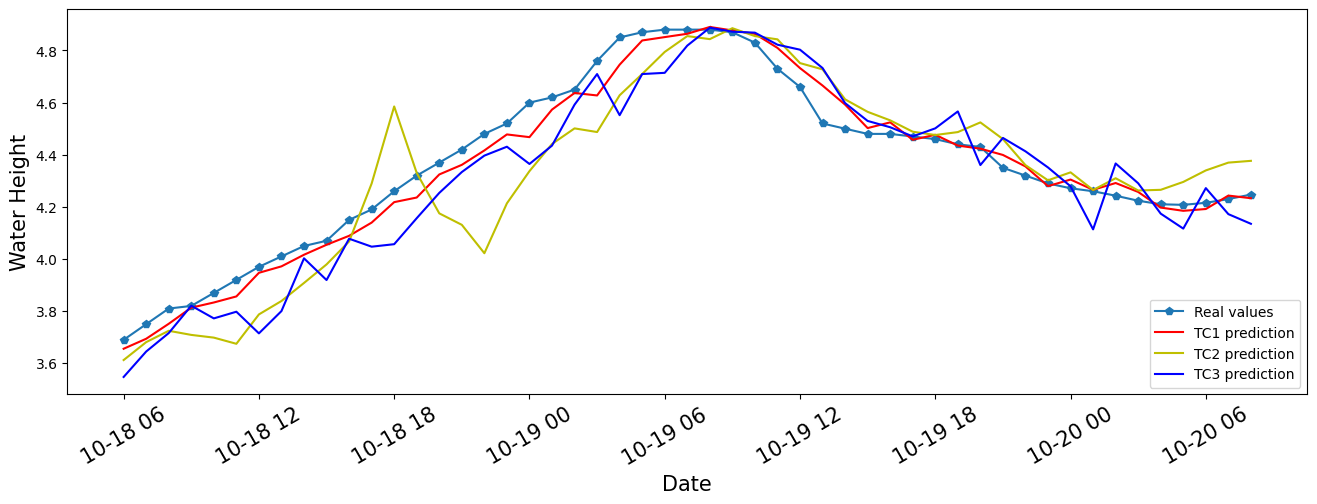

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df_test = pd.read_csv("/content/drive/MyDrive/Forecasting/Datasets/RF/sc0_pred_results_2020-10-17-20h_2020-12-31-23h.csv")
df_test1 = pd.read_csv("/content/drive/MyDrive/Forecasting/Datasets/RF/sc1_pred_results_2020-10-17-20h_2020-12-31-23h.csv")
df_test2 = pd.read_csv("/content/drive/MyDrive/Forecasting/Datasets/RF/sc2_pred_results_2020-10-17-20h_2020-12-31-23h.csv")

df_test['date'] = pd.to_datetime(df_test['date'], format = '%Y-%m-%d %H:%M')
# Adjusting the figure size
fig = plt.subplots(figsize=(16, 5))

# Creating a plot
plt.plot(df_test["date"].loc[10:60], df_test["LT_H"].loc[10:60], "p-",
         df_test["date"].loc[10:60], df_test["pred"].loc[10:60], "r-",
         df_test["date"].loc[10:60], df_test1["pred"].loc[10:60], "y-",
         df_test["date"].loc[10:60], df_test2["pred"].loc[10:60], "b-")

# Adding a plot title and customizing its font size
# plt.title('EUR-CAD rate', fontsize=20)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=15)
plt.ylabel('Water Height', fontsize=15)

plt.legend(["Real values", "TC1 prediction", "TC2 prediction", "TC3 prediction"], loc ="lower right")

# Rotaing axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=15)

# Changing the plot resolution - zooming in the period from 15.12.2022 till 15.01.2023
# plt.xlim(pd.Timestamp('2020-10-17 20:00:00'), pd.Timestamp('2020-12-31 23:00:00'))

(array([18553.25, 18553.5 , 18553.75, 18554.  , 18554.25, 18554.5 ,
        18554.75, 18555.  , 18555.25]),
 [Text(18553.25, 0, '10-18 06'),
  Text(18553.5, 0, '10-18 12'),
  Text(18553.75, 0, '10-18 18'),
  Text(18554.0, 0, '10-19 00'),
  Text(18554.25, 0, '10-19 06'),
  Text(18554.5, 0, '10-19 12'),
  Text(18554.75, 0, '10-19 18'),
  Text(18555.0, 0, '10-20 00'),
  Text(18555.25, 0, '10-20 06')])

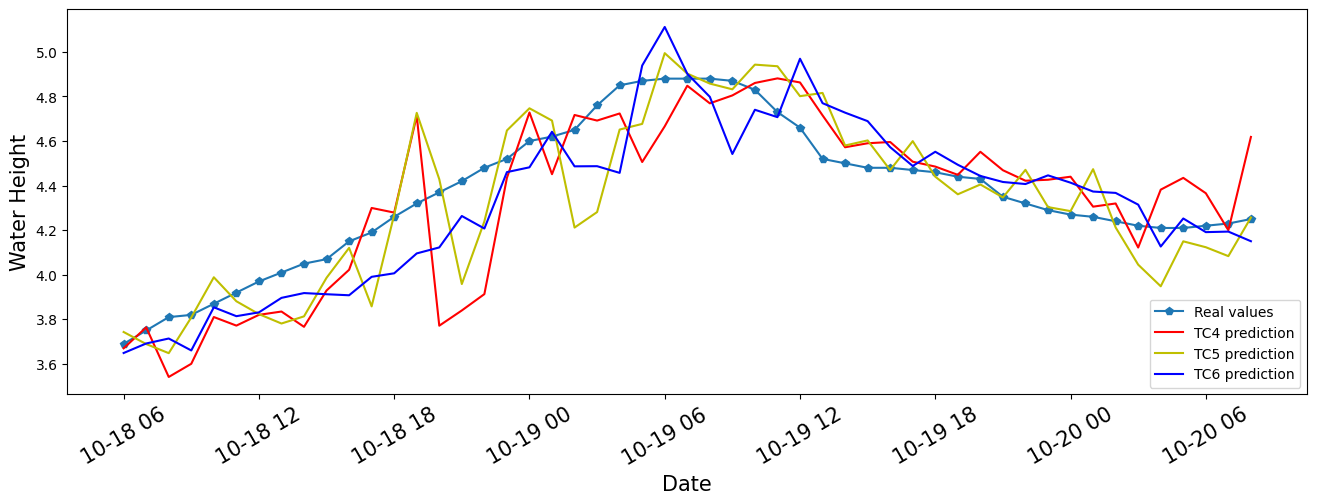

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df_test = pd.read_csv("/content/drive/MyDrive/DATA/predict_data/TC4_v2_prediction.csv")
df_test1 = pd.read_csv("/content/drive/MyDrive/DATA/predict_data/TC5_v1_prediction.csv")
df_test2 = pd.read_csv("/content/drive/MyDrive/DATA/predict_data/TC6_v2_prediction.csv")

df_test['date'] = pd.to_datetime(df_test['date'], format = '%m/%d/%Y %H:%M')
# Adjusting the figure size
fig = plt.subplots(figsize=(16, 5))

# Creating a plot
plt.plot(df_test["date"].loc[10:60], df_test["LT_H"].loc[10:60], "p-",
         df_test["date"].loc[10:60], df_test["pred"].loc[10:60], "r-",
         df_test["date"].loc[10:60], df_test1["pred"].loc[10:60], "y-",
         df_test["date"].loc[10:60], df_test2["pred"].loc[10:60], "b-")

# Adding a plot title and customizing its font size
# plt.title('EUR-CAD rate', fontsize=20)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=15)
plt.ylabel('Water Height', fontsize=15)

plt.legend(["Real values", "TC4 prediction", "TC5 prediction", "TC6 prediction"], loc ="lower right")

# Rotaing axis ticks and customizing their font size
plt.xticks(rotation=30, fontsize=15)

# Changing the plot resolution - zooming in the period from 15.12.2022 till 15.01.2023
# plt.xlim(pd.Timestamp('2020-10-17 20:00:00'), pd.Timestamp('2020-12-31 23:00:00'))

In [ ]:
df_test

In [ ]:
plt.show()